In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('ticks')
sns.set_context('notebook')

In [2]:
import curveball

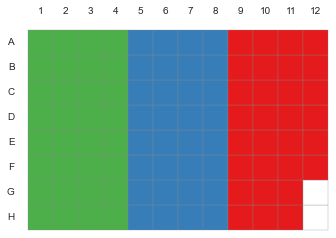

In [3]:
plate = pd.read_csv(r"D:/workspace/curveball_project/python/plate_templates/G-RG-R.csv")
fig,ax = curveball.plots.plot_plate(plate)

['G' 'RG' 'R' '0']


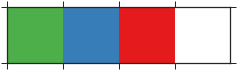

In [4]:
sns.palplot(plate.Color.unique())
print plate.Strain.unique()

In [5]:
filename = r"../data/yoavram/Tecan_210115.xlsx"
df = curveball.ioutils.read_tecan_xlsx(filename, ('OD','Green','Red'), max_time=14, plate=plate)

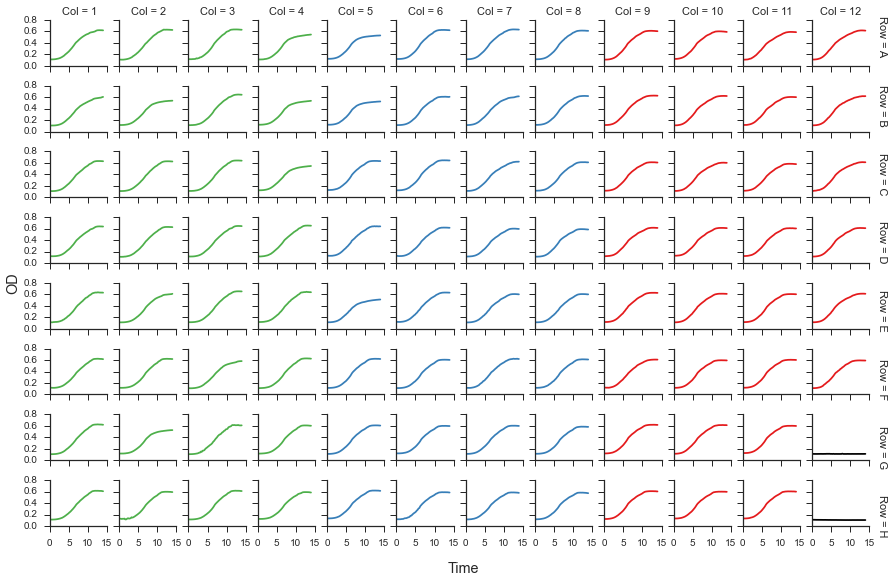

In [6]:
g = curveball.plots.plot_wells(df, 'Time', 'OD')

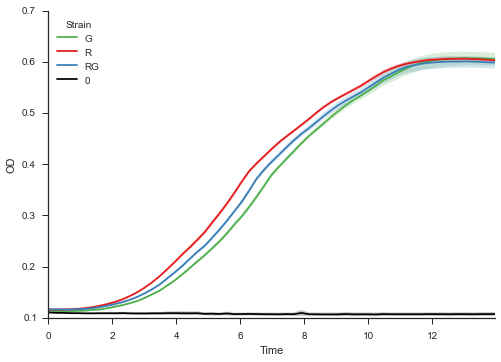

In [7]:
g = curveball.plots.tsplot(df)

[[Model]]
    Model(baranyi_roberts_function)
[[Fit Statistics]]
    # function evals   = 178
    # data points      = 61
    # variables        = 5
    chi-square         = 13.435
    reduced chi-square = 0.240
[[Variables]]
    y0:   0.11553858 +/- 0.001475 (1.28%) (init= 0.1159133)
    r:    0.48952635 +/- 0.006992 (1.43%) (init= 0.02443922)
    K:    0.62321863 +/- 0.001979 (0.32%) (init= 0.6064833)
    nu:   1 (fixed)
    q0:   0.02697265 +/- 0.009056 (33.58%) (init= 1)
    v:    1.52956844 +/- 0.145671 (9.52%) (init= 1)



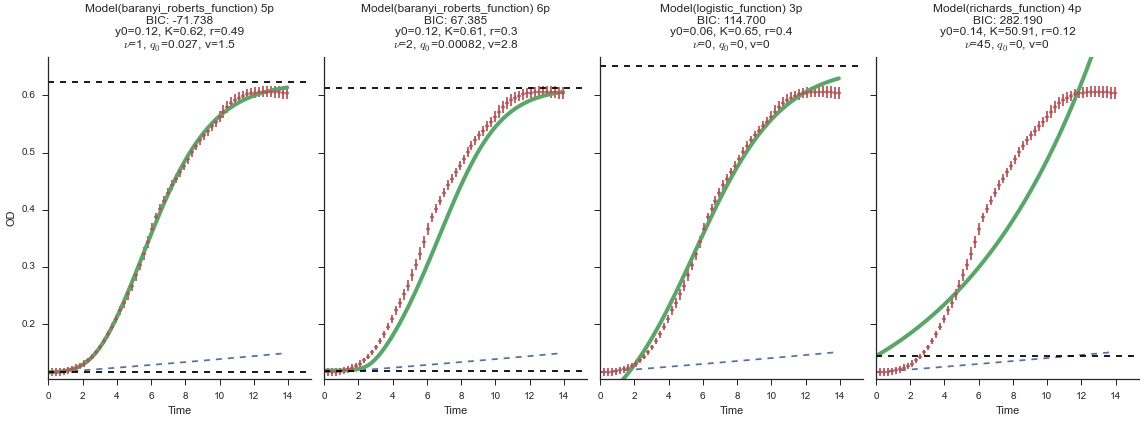

In [8]:
df_RG = df[df.Strain == 'R']
models_RG,fig,ax = curveball.models.fit_model(df_RG)

# Cook's distance

In [35]:
reload(curveball.models)

<module 'curveball.models' from 'd:\workspace\curveball_project\python\curveball\models.py'>

In [26]:
model_fit = curveball.models.fit_model(df_RG, PLOT=False, PRINT=False)[0]

In [27]:
D = curveball.models.cooks_distance(df_RG, model_fit)

In [28]:
set(D.keys()) == set(df_RG.Well)

True

In [29]:
(np.array(D.values()) < 14).all() and (11 < np.array(D.values())).all() 

True

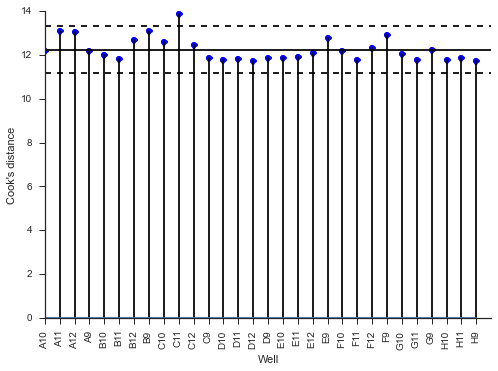

In [30]:
outliers,fig,ax = curveball.models.find_outliers(df_RG, model_fit, PLOT=True)

In [33]:
outliers = pd.Series(outliers)
outliers.isin(df_RG.Well).all()

True

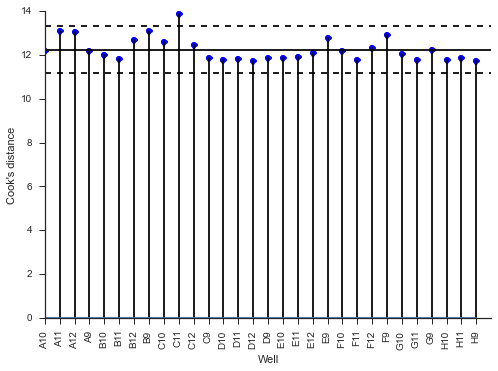

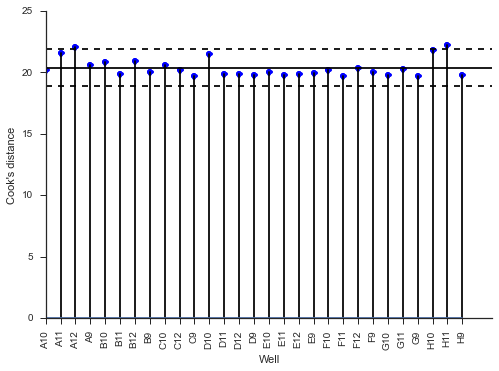

In [36]:
outliers,fig,ax = curveball.models.find_all_outliers(df_RG, model_fit, PLOT=True)

In [ ]:
pd.Series(sum(outliers,[])).isin(df_RG.Well).all()
outliers

In [ ]:
outliers = sum(outliers, [])
print "Outliers:", outliers
original = len(df_RG.Well.unique())
remaining = original - len(outliers)
print "Remaining wells %d out of %d" % (remaining, original)

In [ ]:
models_RG,fig,ax = curveball.models.fit_model(df_RG)

In [ ]:
models_RG_clean,fig,ax = curveball.models.fit_model(df_RG[~df_RG.Well.isin(outliers)])

In [ ]:
curveball.plots.plot_wells(df[~df.Well.isin(outliers)])

In [ ]:
curveball.plots.plot_wells(df[df.Well.isin(outliers)])

In [ ]:
curveball.plots.tsplot(df[~df.Well.isin(outliers)])